In [1]:
# imports
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import json

In [2]:
def load_image(img_path):
    return cv2.imread(img_path)

camera_calibration_data = {}

# Preprocessing

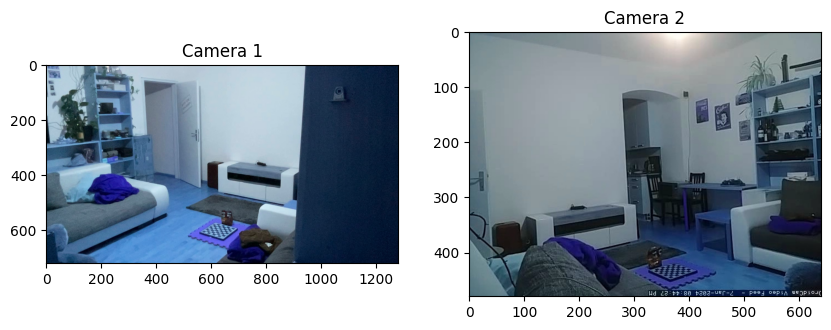

In [3]:
cam1_image = load_image('./cam1_chess_floor.jpg')
cam2_image = load_image('./cam2_chess_floor.jpg')

# Display the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cam1_image)
plt.title('Camera 1')

plt.subplot(1, 2, 2)
plt.imshow(cam2_image)
plt.title('Camera 2')
plt.show()

In [ ]:
# # flipping images (optional)
# print(type(cam2_image))
# cam2_image_flipped = np.flipud(cam2_image)
# cam2_image_flipped = np.fliplr(cam2_image_flipped)

In [ ]:
# # save flipped image
# cv2.imwrite('cam2_chess_floor.jpg', cam2_image_flipped)

# ROI Selection

In [4]:
# Function to select ROI and zoom
def select_and_zoom(image):
    # Use OpenCV to select the ROI
    r = cv2.selectROI(image)

    # Crop image
    roi = image[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]
    
    # You may want to upsample the ROI for a closer look
    roi_zoomed = cv2.resize(roi, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    
    return roi_zoomed

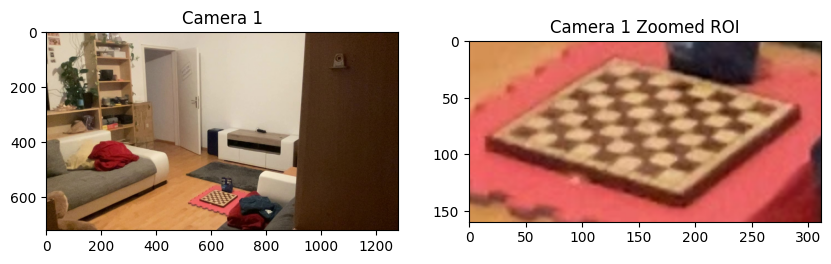

In [5]:
cam1_image_zoomed = select_and_zoom(cam1_image)

# Display the zoomed ROIs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cam1_image, cv2.COLOR_BGR2RGB))
plt.title('Camera 1')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(cam1_image_zoomed, cv2.COLOR_BGR2RGB))
plt.title('Camera 1 Zoomed ROI')
plt.show()

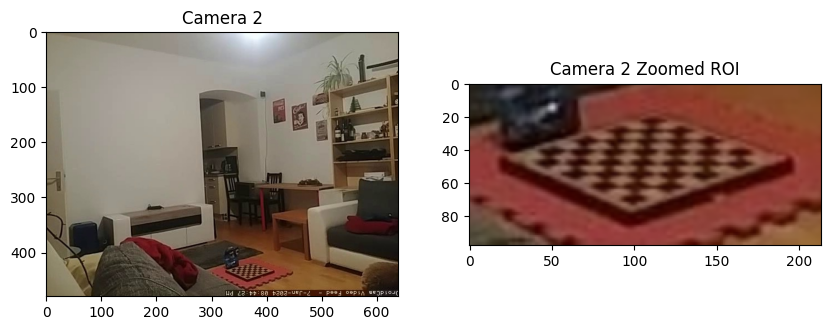

In [6]:
cam2_image_zoomed = select_and_zoom(cam2_image)

# Display the zoomed ROIs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cam2_image, cv2.COLOR_BGR2RGB))
plt.title('Camera 2')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(cam2_image_zoomed, cv2.COLOR_BGR2RGB))
plt.title('Camera 2 Zoomed ROI')
plt.show()

# Corner Selection

In [7]:
import cv2
import numpy as np

# Function to manually select corner points
def select_corners(image, scale_factor=2):
    # Resize the image for easier point selection
    display_image = cv2.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_LINEAR)
    
    # Create a copy of the image for displaying the points
    image_copy = display_image.copy()
    
    # Initialize a list to store the coordinates of the corners
    corners = []

    def mouse_callback(event, x, y, flags, param):
        # Left button click event
        if event == cv2.EVENT_LBUTTONDOWN:
            # Adjust the coordinates based on the scale factor
            original_x, original_y = int(x / scale_factor), int(y / scale_factor)
            # Store the coordinates of the click
            corners.append((original_x, original_y))
            # Draw a small circle at the location of the click on the display image
            cv2.circle(image_copy, (x, y), 5, (0, 255, 0), -1)
            cv2.imshow('Select Corners', image_copy)
    
    # Show the image and set the mouse callback function
    cv2.imshow('Select Corners', image_copy)
    cv2.setMouseCallback('Select Corners', mouse_callback)
    
    # Wait until 'q' is pressed
    print("Click on each corner of the chessboard. Press 'q' when done.")
    while True:
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q') or len(corners) == 4:
            break
    
    # Close the image window
    cv2.destroyAllWindows()
    return corners



In [8]:
# Manually select the corner points on each image
corners_cam1 = select_corners(cam1_image_zoomed, scale_factor=800 / np.max(cam1_image_zoomed.shape))
# Now you have the corner points selected for each camera's ROI
print("Camera 1 Corners:", corners_cam1)


Click on each corner of the chessboard. Press 'q' when done.
Camera 1 Corners: [(129, 15), (286, 57), (187, 134), (21, 83)]


In [9]:
# Manually select the corner points on each image
corners_cam2 = select_corners(cam2_image_zoomed, scale_factor=800 / np.max(cam2_image_zoomed.shape))
# Now you have the corner points selected for each camera's ROI
print("Camera 2 Corners:", corners_cam2)

Click on each corner of the chessboard. Press 'q' when done.
Camera 2 Corners: [(23, 44), (111, 17), (190, 45), (98, 77)]


# Homography

In [10]:
# load camera calibration data from pickle file
with open('camera_calibration_data.pkl', 'rb') as f:
    camera_calibration_data = pickle.load(f)
camera_calibration_data

{'camera1': {'camera_matrix': array([[5.72432532e+03, 0.00000000e+00, 5.25844873e+02],
         [0.00000000e+00, 5.57996833e+03, 6.97995810e+02],
         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
  'distortion_coefficients': array([[ 2.95908897e+00, -1.28632219e+02,  4.55866885e-04,
           6.17156330e-02, -5.36117618e+03]]),
  'rotation_vectors': (array([[ 0.0161583 ],
          [-0.18935833],
          [-0.01631678]]),),
  'translation_vectors': (array([[-3.9890466 ],
          [-1.74570367],
          [66.55924777]]),)},
 'camera2': {'camera_matrix': array([[3.26502591e+03, 0.00000000e+00, 1.14423353e+03],
         [0.00000000e+00, 3.30793674e+03, 2.61250764e+02],
         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
  'distortion_coefficients': array([[ 7.88207645e-01, -1.17103670e+01, -5.01280887e-03,
           2.87900078e-02,  6.57724664e+01]]),
  'rotation_vectors': (array([[ 0.14576796],
          [-0.10586212],
          [ 0.00162079]]),),
  'translation_

In [12]:
# Function to compute the homography matrix from points on a chessboard
def compute_homography(src_points, dst_points):
    # Calculate the homography matrix
    homography_matrix, _ = cv2.findHomography(src_points, dst_points)
    return homography_matrix

In [13]:
# Convert list of tuples to numpy array
corners_cam1_list = np.array(corners_cam1, dtype="float32")

# Now you can calculate side_length
side_length = max(corners_cam1_list[:, 0]) - min(corners_cam1_list[:, 0])

# Define the destination points
dst_points = np.array([
    [0, 0],
    [side_length, 0],
    [side_length, side_length],
    [0, side_length]
], dtype="float32")

# Compute the homography matrix for each camera
homography_cam1 = compute_homography(corners_cam1_list, dst_points)
# Print out the homography matrices
print("Homography Matrix Camera 1:", homography_cam1)



Homography Matrix Camera 1: [[ 1.28648955e+00  2.04324810e+00 -1.96605873e+02]
 [-8.21446578e-01  3.07064554e+00  5.99069255e+01]
 [ 6.42199367e-06  1.47689879e-03  1.00000000e+00]]


In [14]:
_, rotations_cam1, translations_cam1, normals_cam1 = cv2.decomposeHomographyMat(homography_cam1, camera_calibration_data["camera1"]["camera_matrix"])
print("Homography Matrix Camera 1:\n", homography_cam1)
for i, (rotation, translation) in enumerate(zip(rotations_cam1, translations_cam1)):
    print(f"Solution {i+1}:")
    print("Rotation:\n", rotation)
    print("Translation:\n", translation)

Homography Matrix Camera 1:
 [[ 1.28648955e+00  2.04324810e+00 -1.96605873e+02]
 [-8.21446578e-01  3.07064554e+00  5.99069255e+01]
 [ 6.42199367e-06  1.47689879e-03  1.00000000e+00]]
Solution 1:
Rotation:
 [[ 0.8282521   0.55460832  0.08005045]
 [-0.55711944  0.83035384  0.01142023]
 [-0.06013645 -0.05405649  0.99672539]]
Translation:
 [[0.24653627]
 [0.4933488 ]
 [5.40853122]]
Solution 2:
Rotation:
 [[ 0.8282521   0.55460832  0.08005045]
 [-0.55711944  0.83035384  0.01142023]
 [-0.06013645 -0.05405649  0.99672539]]
Translation:
 [[-0.24653627]
 [-0.4933488 ]
 [-5.40853122]]
Solution 3:
Rotation:
 [[ 0.84498216 -0.36231565 -0.39336054]
 [-0.52962682 -0.46492678 -0.70946355]
 [ 0.0741659   0.80781833 -0.58474692]]
Translation:
 [[1.26133558]
 [1.93886114]
 [4.91998305]]
Solution 4:
Rotation:
 [[ 0.84498216 -0.36231565 -0.39336054]
 [-0.52962682 -0.46492678 -0.70946355]
 [ 0.0741659   0.80781833 -0.58474692]]
Translation:
 [[-1.26133558]
 [-1.93886114]
 [-4.91998305]]


In [15]:
# Convert list of tuples to numpy array
corners_cam2_list = np.array(corners_cam2, dtype="float32")

# Now you can calculate side_length
side_length = max(corners_cam2_list[:, 0]) - min(corners_cam2_list[:, 0])

# Define the destination points
dst_points = np.array([
    [0, 0],
    [side_length, 0],
    [side_length, side_length],
    [0, side_length]
], dtype="float32")

# Compute the homography matrix for each camera
homography_cam2 = compute_homography(corners_cam2_list, dst_points)
# Print out the homography matrices
print("Homography Matrix Camera 1:", homography_cam2)

Homography Matrix Camera 1: [[ 1.20946248e+00 -2.74877836e+00  9.31286108e+01]
 [ 1.17016517e+00  3.81387167e+00 -1.94724153e+02]
 [ 2.24940636e-04  3.33920015e-03  1.00000000e+00]]


In [16]:
_, rotations_cam2, translations_cam2, normals_cam2 = cv2.decomposeHomographyMat(homography_cam2, camera_calibration_data["camera2"]["camera_matrix"])
print("Homography Matrix Camera 2:\n", homography_cam1)
for i, (rotation, translation) in enumerate(zip(rotations_cam2, translations_cam2)):
    print(f"Solution {i+1}:")
    print("Rotation:\n", rotation)
    print("Translation:\n", translation)

Homography Matrix Camera 2:
 [[ 1.28648955e+00  2.04324810e+00 -1.96605873e+02]
 [-8.21446578e-01  3.07064554e+00  5.99069255e+01]
 [ 6.42199367e-06  1.47689879e-03  1.00000000e+00]]
Solution 1:
Rotation:
 [[ 0.80464404 -0.57472824 -0.14911543]
 [ 0.59325853  0.76790801  0.24158147]
 [-0.02433676 -0.28285109  0.95885504]]
Translation:
 [[-3.44629016]
 [ 1.00740431]
 [ 6.96006842]]
Solution 2:
Rotation:
 [[ 0.80464404 -0.57472824 -0.14911543]
 [ 0.59325853  0.76790801  0.24158147]
 [-0.02433676 -0.28285109  0.95885504]]
Translation:
 [[ 3.44629016]
 [-1.00740431]
 [-6.96006842]]
Solution 3:
Rotation:
 [[ 0.5360797   0.06466365  0.8416871 ]
 [ 0.68279868 -0.61951158 -0.38728719]
 [ 0.4963915   0.78231964 -0.37625984]]
Translation:
 [[-4.23388324]
 [ 2.48520521]
 [ 6.10182919]]
Solution 4:
Rotation:
 [[ 0.5360797   0.06466365  0.8416871 ]
 [ 0.68279868 -0.61951158 -0.38728719]
 [ 0.4963915   0.78231964 -0.37625984]]
Translation:
 [[ 4.23388324]
 [-2.48520521]
 [-6.10182919]]


## warp images

In [17]:
# Function to apply a homography matrix to an image
def warp_image(image, homography_matrix, width, height):
    # Warp the image using the homography matrix
    warped_image = cv2.warpPerspective(image, homography_matrix, (width, height))
    return warped_image

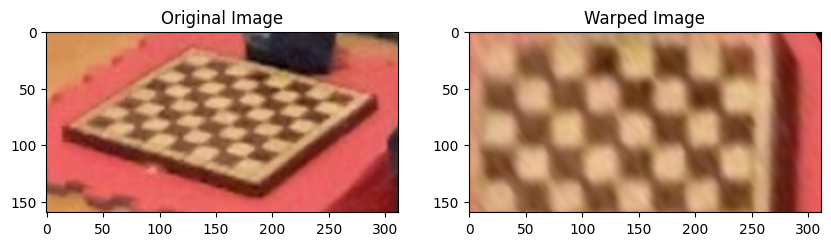

In [18]:
# Define the width and height of the destination image
height, width = cam1_image_zoomed.shape[0:2]  # Example values, you can adjust these as needed

# Assume homography_cam1 is the correct homography matrix you have computed
# Apply the homography to the original image to get the warped image
warped_image_cam1 = warp_image(cam1_image_zoomed, homography_cam1, width, height)


# Display the original and the warped images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cam1_image_zoomed, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(warped_image_cam1, cv2.COLOR_BGR2RGB))
plt.title('Warped Image')
plt.show()

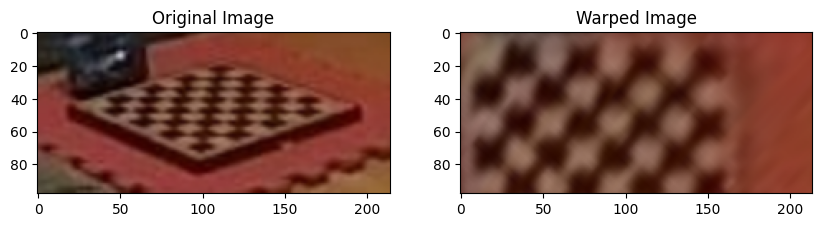

In [19]:
# Define the width and height of the destination image
height2, width2 = cam2_image_zoomed.shape[0:2]  # Example values, you can adjust these as needed

# Assume homography_cam2 is the correct homography matrix you have computed
# Apply the homography to the original image to get the warped image
warped_image_cam2 = warp_image(cam2_image_zoomed, homography_cam2, width2, height2)


# Display the original and the warped images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cam2_image_zoomed, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(warped_image_cam2, cv2.COLOR_BGR2RGB))
plt.title('Warped Image')
plt.show()

In [20]:
# Function to annotate points on an image
def annotate_points(image, points, color=(0, 255, 0)):
    annotated_image = image.copy()
    for point in points:
        cv2.circle(annotated_image, tuple(int(x) for x in point), 5, color, -1)
    return annotated_image

# Function to annotate points on an image with numbers
def annotate_points_with_numbers(image, points, color=(0, 255, 0)):
    annotated_image = image.copy()
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    thickness = 2

    for idx, point in enumerate(points):
        cv2.circle(annotated_image, tuple(int(x) for x in point), 5, color, -1)
        cv2.putText(annotated_image, str(idx+1), (int(point[0]), int(point[1]) - 10), font, font_scale, color, thickness)
    
    return annotated_image

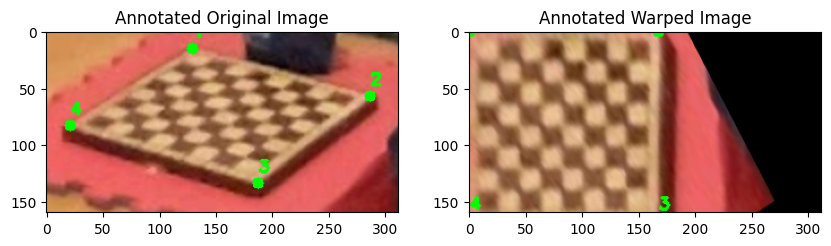

In [21]:
# Annotate the points on the original image
# annotated_original_image_cam1 = annotate_points(cam1_image_zoomed, corners_cam1)
annotated_original_image_cam1 = annotate_points_with_numbers(cam1_image_zoomed, corners_cam1)

# Compute the homography matrix using the selected points
homography_matrix_cam1 = compute_homography(np.array(corners_cam1, dtype="float32"), dst_points)

# Apply the homography to the original image to get the warped image
warped_image_cam1 = cv2.warpPerspective(cam1_image_zoomed, homography_matrix_cam1, (width, height))

# Annotate the points on the warped image using the homography matrix
warped_points_cam1 = cv2.perspectiveTransform(np.array([corners_cam1], dtype="float32"), homography_matrix_cam1)
# annotated_warped_image_cam1 = annotate_points(warped_image_cam1, warped_points_cam1[0])
annotated_warped_image_cam1 = annotate_points_with_numbers(warped_image_cam1, warped_points_cam1[0])  # Use the same points for illustration


# Display the annotated original and warped images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(annotated_original_image_cam1, cv2.COLOR_BGR2RGB))
plt.title('Annotated Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(annotated_warped_image_cam1, cv2.COLOR_BGR2RGB))
plt.title('Annotated Warped Image')
plt.show()

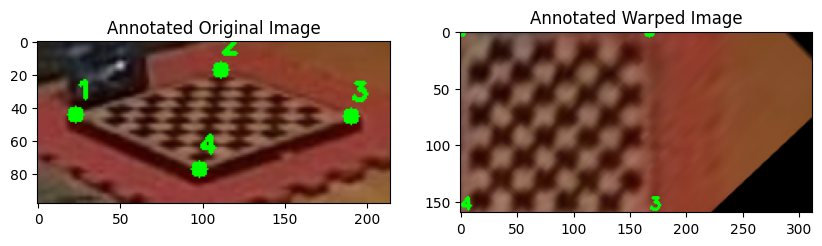

In [22]:
# Annotate the points on the original image
# annotated_original_image_cam2 = annotate_points(cam2_image_zoomed, corners_cam2)
annotated_original_image_cam2 = annotate_points_with_numbers(cam2_image_zoomed, corners_cam2)

# Compute the homography matrix using the selected points
homography_matrix_cam2 = compute_homography(np.array(corners_cam2, dtype="float32"), dst_points)

# Apply the homography to the original image to get the warped image
warped_image_cam2 = cv2.warpPerspective(cam2_image_zoomed, homography_matrix_cam2, (width, height))

# Annotate the points on the warped image using the homography matrix
warped_points_cam2 = cv2.perspectiveTransform(np.array([corners_cam2], dtype="float32"), homography_matrix_cam2)
# annotated_warped_image_cam2 = annotate_points(warped_image_cam2, warped_points_cam2[0])
annotated_warped_image_cam2 = annotate_points_with_numbers(warped_image_cam2, warped_points_cam2[0])  # Use the same points for illustration


# Display the annotated original and warped images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(annotated_original_image_cam2, cv2.COLOR_BGR2RGB))
plt.title('Annotated Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(annotated_warped_image_cam2, cv2.COLOR_BGR2RGB))
plt.title('Annotated Warped Image')
plt.show()

## cam2 to cam1

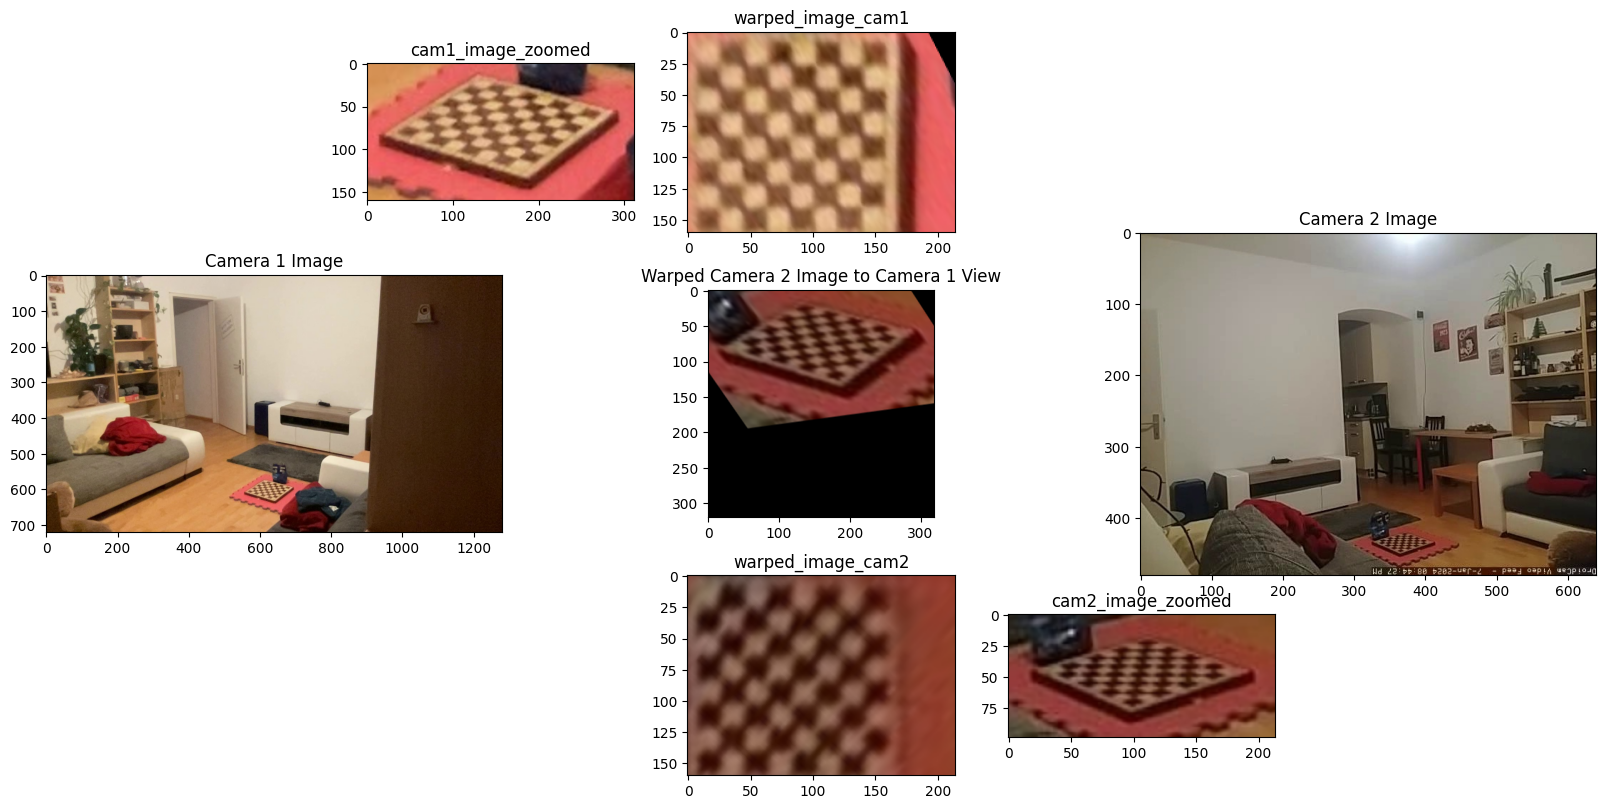

In [24]:
# Assume corners_cam2 are the points selected on Camera 2's image
corners_cam2_cycled = np.array([corners_cam2[1], corners_cam2[2], corners_cam2[3], corners_cam2[0]], dtype="float32")
# corners_cam2_cycled = np.array([corners_cam2[3], corners_cam2[0], corners_cam2[1], corners_cam2[2]], dtype="float32")

# Calculate the homography matrix from Camera 2 to Camera 1
H_cam2_to_cam1, _ = cv2.findHomography(np.array(corners_cam2_cycled, dtype="float32"), np.array(corners_cam1, dtype="float32"))

# Warp Camera 2's image to the perspective of Camera 1
height, width = cam1_image.shape[:2]
warped_cam2_to_cam1 = cv2.warpPerspective(cam2_image_zoomed, H_cam2_to_cam1, (width, height))

warped_points_cam2_to_cam1 = cv2.perspectiveTransform(np.array([corners_cam2_cycled], dtype="float32"), H_cam2_to_cam1)
annotated_warped_cam2_to_cam1 = annotate_points_with_numbers(warped_points_cam2_to_cam1, corners_cam2_cycled)

# Display the result
plt.figure(figsize=(20, 10))
plt.subplot(3, 5, 2)
plt.imshow(cv2.cvtColor(cam1_image_zoomed, cv2.COLOR_BGR2RGB))
plt.title('cam1_image_zoomed')
plt.subplot(3, 5, 3)
plt.imshow(cv2.cvtColor(warped_image_cam1[:width2, :width2], cv2.COLOR_BGR2RGB))
plt.title('warped_image_cam1')

plt.subplot(3, 3, 5)
plt.imshow(cv2.cvtColor(warped_cam2_to_cam1[:320, :320], cv2.COLOR_BGR2RGB))
plt.title('Warped Camera 2 Image to Camera 1 View')

plt.subplot(3, 5, 13)
plt.imshow(cv2.cvtColor(warped_image_cam2[:width2, :width2], cv2.COLOR_BGR2RGB))
plt.title('warped_image_cam2')
plt.subplot(3, 5, 14)
plt.imshow(cv2.cvtColor(cam2_image_zoomed, cv2.COLOR_BGR2RGB))
plt.title('cam2_image_zoomed')


plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(cam1_image, cv2.COLOR_BGR2RGB))
plt.title('Camera 1 Image')


plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(cam2_image, cv2.COLOR_BGR2RGB))
plt.title('Camera 2 Image')

plt.show()


In [25]:
import cv2
import numpy as np

# Assume you've placed the chessboard on the floor and you know the real-world coordinates
# of the chessboard corners (in meters, for example)
# The points need to be in the same order as the image points used for homography
world_points = np.array([
    [0, 0, 0],  # Bottom-left corner
    [0.2, 0, 0],  # Bottom-right corner (20cm from the bottom-left corner)
    [0.2, 0.2, 0],  # Top-right corner (20cm up from the bottom-right corner)
    [0, 0.2, 0]  # Top-left corner (20cm up from the bottom-left corner)
], dtype="float32")

# Image points are the corners selected on the chessboard image from camera 1
# They need to be in the same order as world points
    # image_points_cam1 = np.array(corners_cam1, dtype="float32")

# Camera intrinsic parameters from calibration
    # camera_matrix = camera_calibration_data["camera1"]["camera_matrix"]
    # dist_coeffs = camera_calibration_data["camera1"]["distortion_coefficients"]

# Solve PnP to get rotation and translation vectors
    # _, rvec, tvec = cv2.solvePnP(world_points, image_points_cam1, camera_matrix, dist_coeffs)

# Convert rotation vector to rotation matrix
    # R, _ = cv2.Rodrigues(rvec)

# Invert the transformation to get the camera's position in world coordinates
    # camera_position = -np.matrix(R).T * np.matrix(tvec)

    # print(f"Camera Position in World Coordinates:\n{camera_position}")
    # print(f"Camera Rotation Matrix:\n{R}")


In [26]:
def get_camera_position(image_points, world_points, camera_calibration_data):
    camera_matrix = camera_calibration_data["camera_matrix"]
    dist_coeffs = camera_calibration_data["distortion_coefficients"]

    # Solve PnP to get rotation and translation vectors
    _, rvec, tvec = cv2.solvePnP(world_points, image_points, camera_matrix, dist_coeffs)

    # Convert rotation vector to rotation matrix
    R, _ = cv2.Rodrigues(rvec)

    # Invert the transformation to get the camera's position in world coordinates
    camera_position = -np.matrix(R).T * np.matrix(tvec)

    return camera_position, R


In [27]:
image_points_cam1 = np.array(corners_cam1, dtype="float32")
cam1_positoion, cam1_rotation = get_camera_position(image_points_cam1, world_points, camera_calibration_data["camera1"])
print(f"Camera 1 Position in World Coordinates:\n{cam1_positoion}")
print(f"Camera 1 Rotation Matrix:\n{cam1_rotation}")

print()

image_points_cam2 = np.array(corners_cam2, dtype="float32")
cam2_positoion, cam2_rotation = get_camera_position(image_points_cam2, world_points, camera_calibration_data["camera2"])
print(f"Camera 2 Position in World Coordinates:\n{cam2_positoion}")
print(f"Camera 2 Rotation Matrix:\n{cam2_rotation}")

Camera 1 Position in World Coordinates:
[[ 0.66397043]
 [ 3.418443  ]
 [-1.55239803]]
Camera 1 Rotation Matrix:
[[ 0.82357283 -0.28699124 -0.48924822]
 [ 0.56677548  0.38260654  0.72964223]
 [-0.02221135 -0.87820741  0.47776395]]

Camera 2 Position in World Coordinates:
[[-3.63990195]
 [ 4.84857193]
 [-2.5694185 ]]
Camera 2 Rotation Matrix:
[[ 0.56173927  0.82484198 -0.06391161]
 [-0.33877059  0.29981322  0.89182202]
 [ 0.75477379 -0.47932008  0.44784907]]


In [28]:
def plot_cameras_and_chessboard(camera_positions, camera_orientations, camera_labels, chessboard_size=(8, 8)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the chessboard as a grid
    for i in range(chessboard_size[0] + 1):
        ax.plot([i, i], [0, chessboard_size[1]], 'k-')
    for i in range(chessboard_size[1] + 1):
        ax.plot([0, chessboard_size[0]], [i, i], 'k-')

    # Plot each camera position, orientation, and label
    for pos, ori, label in zip(camera_positions, camera_orientations, camera_labels):
        cam_pos = np.array(pos).flatten()
        ax.scatter([cam_pos[0]], [cam_pos[1]], [cam_pos[2]], color='r', s=100)
        ax.text(cam_pos[0], cam_pos[1], cam_pos[2], f'Camera {label}', color='blue')

        # Draw lines indicating the camera's viewing direction
        look_dir = ori[:, 2]  # Assuming the third column is the direction the camera is facing
        ax.quiver(cam_pos[0], cam_pos[1], cam_pos[2], look_dir[0], look_dir[1], look_dir[2], length=1.0, color='b')

    lim = 15
    # Set the limits and labels for all axes
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(0, 6)
    ax.set_xticks(range(-lim, lim+1, 2))
    ax.set_yticks(range(-lim, lim+1, 2))
    ax.set_zticks(range(0, 6, 1))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('3D Visualization of Cameras and Chessboard')
    plt.show()


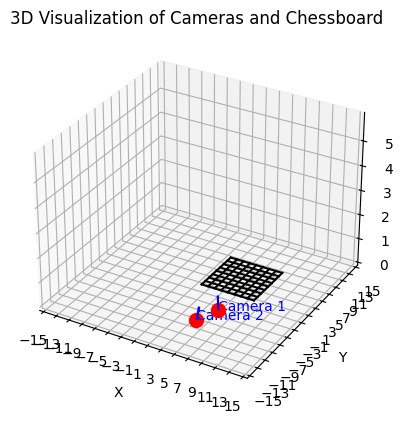

In [29]:
plot_cameras_and_chessboard(
    [cam1_positoion, cam2_positoion], 
    [cam1_rotation, cam2_rotation],
    ['1', '2']
    )

